# disk-space-check

### Problem
In the Integrated Cellular Imaging Core, we control several acquisition computers and workstations. Since disk space is necessary for successful image acquisition, we need to know the disks' status.

### Solution

Scripts send drive info (in .csv format) to a shared cloud storage location. This Jupyter Notebook takes these csv files and puts them into a pandas dataframe for easy viewing.

In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import pandas as pd
import os

In [2]:
# Syncing from server to local storage is taken care of via MS OneDrive

dir_csv = "C:/Users/Will/Emory University/SOM-ICI - Documents/IT/logs/"
csv_files = glob.glob(os.path.join(dir_csv, "*.csv"))

In [3]:
sample_csv_df = pd.read_csv(csv_files[0])
sample_csv_df

,Server Name,Drive Letter,Total Capacity (GB),Free Space (GB),Free Space (%)
0,ENNCFNIKONA1R,C:,451.6,80.7,18 %
1,ENNCFNIKONA1R,D:,"2,794.4","2,006.0",72 %
2,ENNCFNIKONA1R,E:,12.1,5.2,43 %
3,ENNCFNIKONA1R,F:,2.0,1.7,88 %
4,ENNCFNIKONA1R,P:,279.4,52.5,19 %
5,ENNCFNIKONA1R,R:,149.0,88.0,59 %


**Problem**: While this is nice information, we're missing date information.

**Solution**: We'll parse the filename for the day this was done.

The csv files follow the same pattern: `$name_of_computer-yyyy-mm-dd.csv`

We can exploit this by 
1. splitting on "\\\"  via `.split("\\")`
2. selecting the latter part via `[-1]`
3. slicing to ignore the list elements before the date and after the date via `[-14:-4]`

N.B. When Windows created these CSVs, they included commas as the thousands separator. We need to tell Python this via `thousands=","`.

In [4]:
df = pd.concat((pd.read_csv(f, thousands=",").assign(Date = f.split("\\")[-1][-14:-4])
               for f in csv_files),
               ignore_index = True
              )
df.head()

,Server Name,Drive Letter,Total Capacity (GB),Free Space (GB),Free Space (%),Date
0,ENNCFNIKONA1R,C:,451.6,80.7,18 %,2018-05-02
1,ENNCFNIKONA1R,D:,2794.4,2006.0,72 %,2018-05-02
2,ENNCFNIKONA1R,E:,12.1,5.2,43 %,2018-05-02
3,ENNCFNIKONA1R,F:,2.0,1.7,88 %,2018-05-02
4,ENNCFNIKONA1R,P:,279.4,52.5,19 %,2018-05-02


Note that commas no longer make an appearance whenever a number is over 1000.
Since we're working with dates, let's convert the `Date` column from strings to `datetime`s.

In [5]:
df["Date"] = pd.to_datetime(df["Date"].astype(str), format="%Y-%m-%d")
df.head()

,Server Name,Drive Letter,Total Capacity (GB),Free Space (GB),Free Space (%),Date
0,ENNCFNIKONA1R,C:,451.6,80.7,18 %,2018-05-02
1,ENNCFNIKONA1R,D:,2794.4,2006.0,72 %,2018-05-02
2,ENNCFNIKONA1R,E:,12.1,5.2,43 %,2018-05-02
3,ENNCFNIKONA1R,F:,2.0,1.7,88 %,2018-05-02
4,ENNCFNIKONA1R,P:,279.4,52.5,19 %,2018-05-02


In [6]:
computer_names = df["Server Name"].unique()

print("We are tracking {} different computers.\n".format(len(computer_names)))
print(computer_names)

We are tracking 19 different computers.

['ENNCFNIKONA1R' 'FV1000UPRIGHT' 'ICI-WBRB-LH' 'ICI-WBRB-WORK4'
 'ICI_HSRB_FV1000' 'ICI_HSRB_IX71' 'ICI_HSRB_SD' 'ICI_HSRB_SPIM'
 'ICI_HSRB_WORK3' 'ICI_WCI_AXIO' 'ICI_WCI_IX51' 'ICI_WCI_LLS' 'ICI_WCI_PE'
 'ICI_WCI_SP8' 'LEICA-SP8PR-WS' 'NIKONSIM-HP' 'OMX068MASTER'
 'WBRB-FV1000-INV' 'WORKSTATION4-PC']


In [7]:
drive_names = df["Drive Letter"].unique()
print(drive_names)

['C:' 'D:' 'E:' 'F:' 'P:' 'R:' 'G:' 'S:' 'H:' 'Q:' 'O:']


If we wanted to get the latest snapshot of every computer and their drives, we can use `df.groupby(["Server Name", "Drive Letter"]).last()`

In [8]:
df.groupby(["Server Name", "Drive Letter"]).last()

Total Capacity (GB)  Free Space (GB)  \
Server Name     Drive Letter                                         
ENNCFNIKONA1R   C:                          451.6             34.9   
                D:                         2794.4           1591.3   
                E:                           12.1              5.2   
                F:                            2.0              1.7   
                G:                         1863.0           1382.7   
                P:                          279.4             52.5   
                R:                          149.0             88.0   
FV1000UPRIGHT   C:                          104.2             20.2   
                D:                         1863.0           1704.6   
                F:                          238.5            238.4   
ICI-WBRB-LH     C:                          476.4             16.6   
ICI-WBRB-WORK4  C:                          931.0            396.8   
                D:                        11176.9            582.4   
                E:                            0.0              0.0   
ICI_HSRB_FV1000 C:                          931.4            866.1   
                E:                          931.5             48.0   
                G:                          465.8            266.2   
ICI_HSRB_IX71   C:                          111.7             61.6   
                D:                          465.8            248.1   
ICI_HSRB_SD     C:                          195.2            157.5   
                D:                         1852.7           1788.3   
ICI_HSRB_SPIM   C:                          111.7             14.6   
                R:                         5588.8           3779.8   
ICI_HSRB_WORK3  C:                          476.4            149.4   
                D:                        11177.9            486.7   
ICI_WCI_AXIO    C:                           51.3              5.2   
                D:                           97.7             51.4   
ICI_WCI_IX51    C:                          148.9             26.9   
ICI_WCI_LLS     C:                          475.7            221.3   
                E:                         1861.9            259.2   
ICI_WCI_PE      C:                         2047.9           1778.6   
                D:                         5588.8           3110.2   
ICI_WCI_SP8     C:                          119.2             29.7   
                D:                         1863.0            797.8   
                G:                            0.0              0.0   
                R:                          931.4             21.4   
                S:                          232.8            219.9   
LEICA-SP8PR-WS  C:                          149.0             51.1   
                D:                         1863.0            616.3   
                G:                            0.0              0.0   
                H:                            0.0              0.0   
NIKONSIM-HP     C:                          921.4            180.0   
                D:                            8.1              1.0   
                F:                         2794.5           1963.9   
                Q:                            0.0              0.0   
OMX068MASTER    C:                          931.4            139.0   
                O:                         8383.2           3975.1   
WBRB-FV1000-INV C:                          104.2             41.7   
                D:                         1863.0             99.4   
                E:                          238.5            238.4   
                G:                         3726.0           3702.0   
WORKSTATION4-PC C:                          226.1             17.3   
                D:                         2794.4           2126.7   

                             Free Space (%)       Date  
Server Name     Drive Letter                            
ENNCFNIKONA1R   C:                      8 % 2018-11-04  
        

What's the latest report on `C:` drives? We can first select the rows related to the `C:` drive and then pivot by `Server Name`.

To get the latest info, we can use the `last()` method and then sort from lowest to highest through `sort_values()`.

In [9]:
grouped = {"C": None,
           "D": None,
           "E": None,
          }
                      
grouped["C"] = df[df["Drive Letter"] == "C:"].groupby("Server Name")
grouped["D"] = df[df["Drive Letter"] == "D:"].groupby("Server Name")
grouped["E"] = df[df["Drive Letter"] == "E:"].groupby("Server Name")

In [10]:
grouped["C"].last().sort_values(by='Free Space (GB)')

,Drive Letter,Total Capacity (GB),Free Space (GB),Free Space (%),Date
Server Name,,,,,
ICI_WCI_AXIO,C:,51.3,5.2,10 %,2018-11-05
ICI_HSRB_SPIM,C:,111.7,14.6,13 %,2018-11-05
ICI-WBRB-LH,C:,476.4,16.6,3%,2018-10-22
WORKSTATION4-PC,C:,226.1,17.3,8 %,2018-06-26
FV1000UPRIGHT,C:,104.2,20.2,19 %,2018-11-05
ICI_WCI_IX51,C:,148.9,26.9,18 %,2018-11-05
ICI_WCI_SP8,C:,119.2,29.7,25 %,2018-11-05
ENNCFNIKONA1R,C:,451.6,34.9,8 %,2018-11-04
WBRB-FV1000-INV,C:,104.2,41.7,40 %,2018-11-05


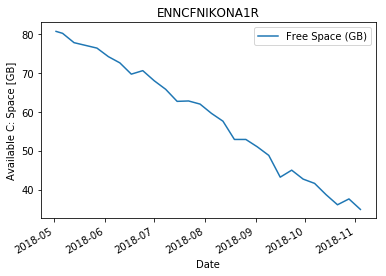

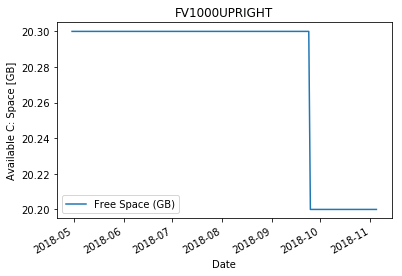

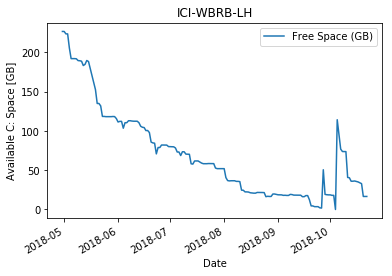

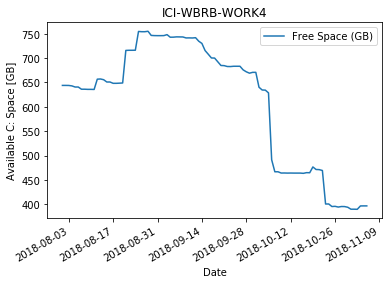

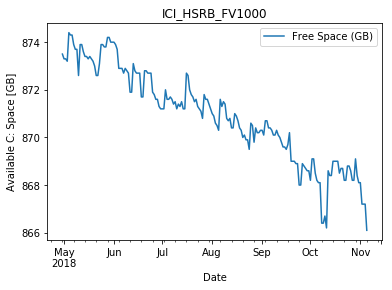

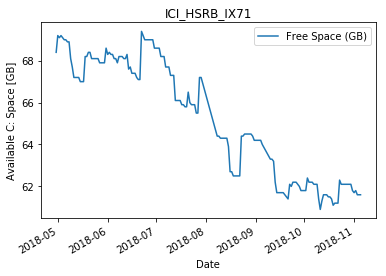

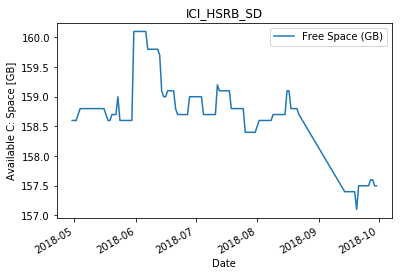

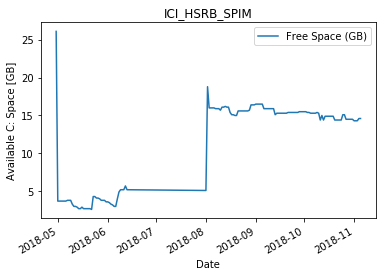

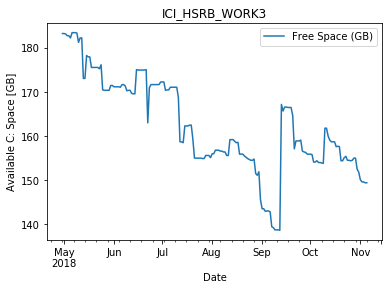

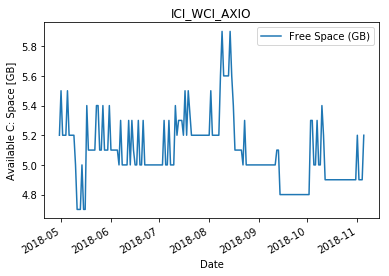

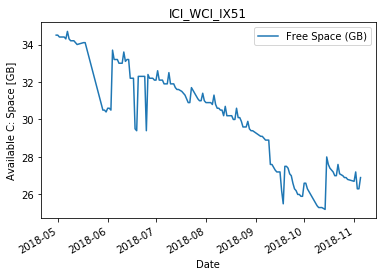

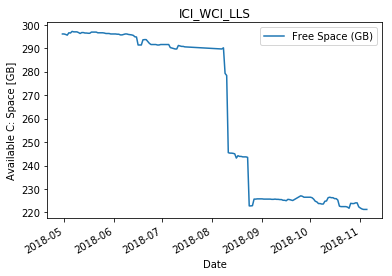

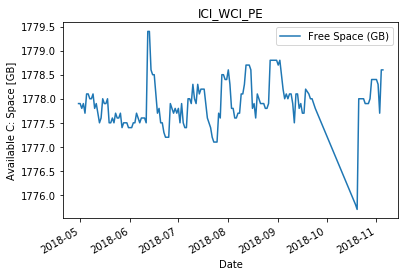

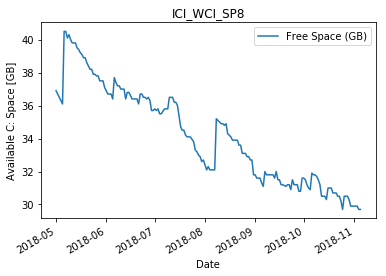

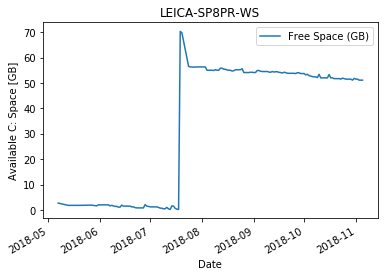

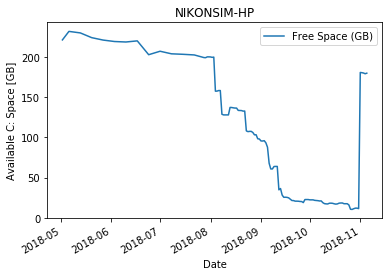

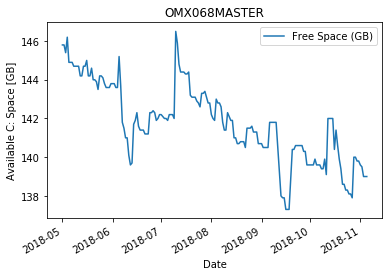

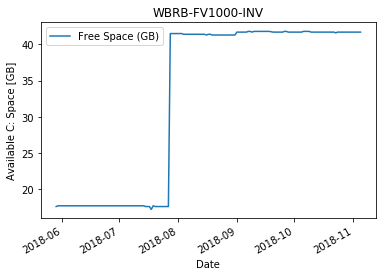

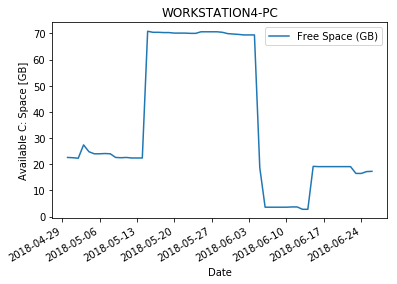

In [11]:
for title, group in grouped["C"]:
    ax = group.plot(x="Date", y="Free Space (GB)", title=title)
    ax.set(ylabel = "Available C: Space [GB]")
    

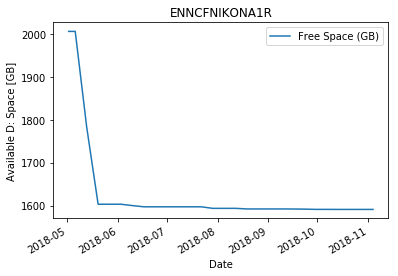

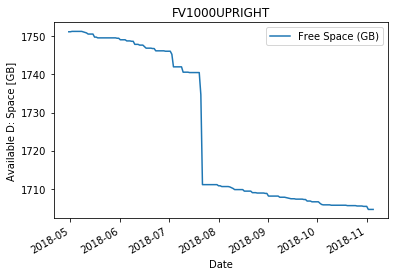

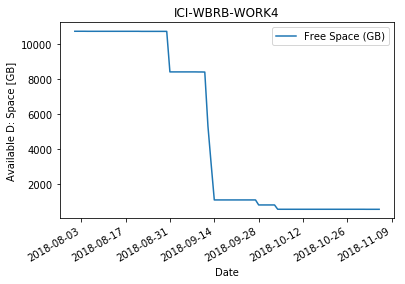

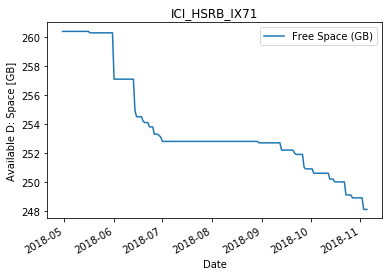

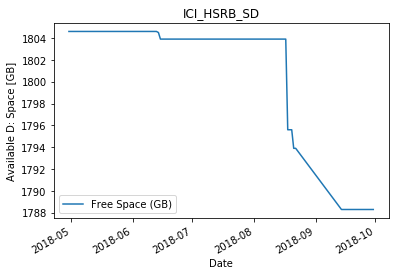

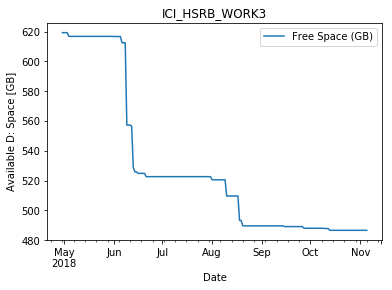

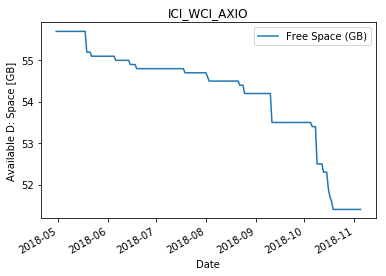

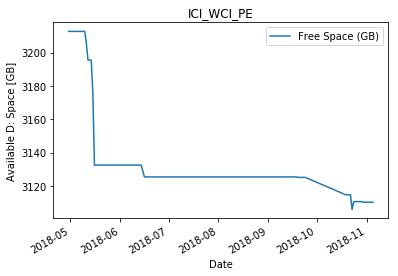

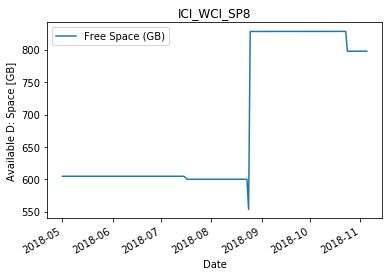

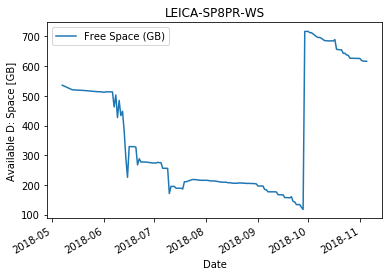

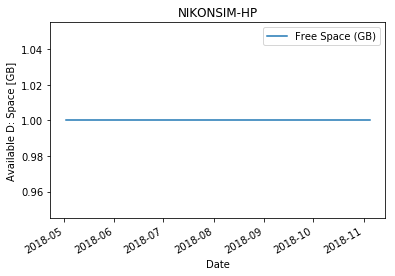

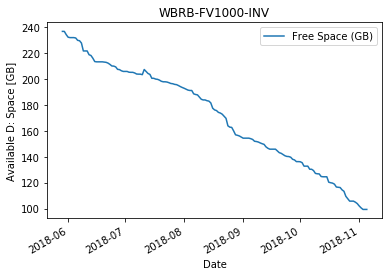

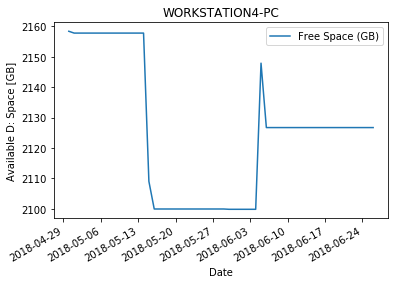

In [12]:
for title, group in grouped["D"]:
    ax = group.plot(x="Date", y="Free Space (GB)", title=title)
    ax.set(ylabel = "Available D: Space [GB]")
    

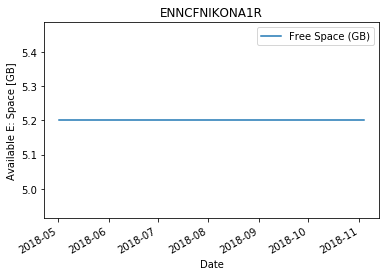

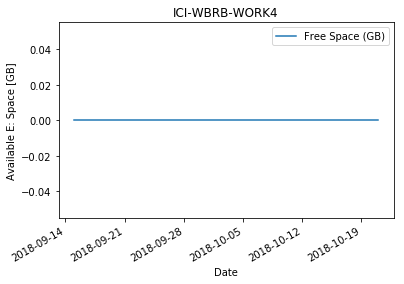

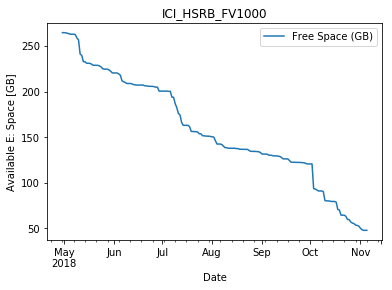

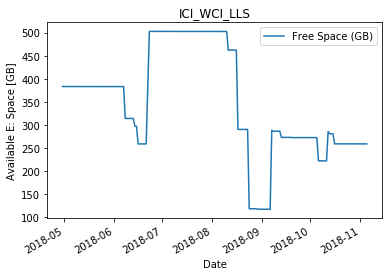

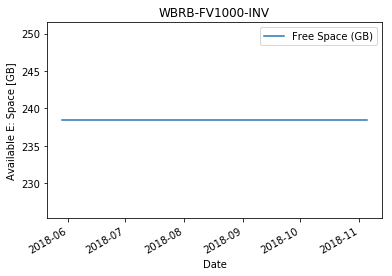

In [13]:
for title, group in grouped["E"]:
    ax = group.plot(x="Date", y="Free Space (GB)", title=title)
    ax.set(ylabel = "Available E: Space [GB]")
    